# Compute $a_0$ by comparing with $\eta$

In [97]:
import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
from datetime import datetime
import h5py

from scipy import signal
from scipy.optimize import minimize

from soda.utils.timeseries import timeseries, skill, rmse
from soda.utils.uspectra import uspectra, getTideFreq
from soda.utils.othertime import SecondsSince, TimeVector

#from iwaves.kdv.solve import solve_kdv
from iwaves.kdv.vkdv import  vKdV

from soda.dataio.conversion import readotps
from soda.utils.myairsea import pol2cart


import seaborn as sns
import pymc3 as pm
from theano import shared
from theano import tensor as tt

import matplotlib as mpl

import yaml

In [2]:
%matplotlib notebook

# Load the pre-computed amplitude data

$a_0$ is found here via nonlinear optimization of the KdV model in 24-hr time blocks.

In [3]:
# Load the pre-computed data
csvfile = '../data/ekdv_Prelude_results.csv'

# This is the good file!!!

data = pd.read_csv(csvfile, sep=',', parse_dates=['time','timemax'], index_col='time')

data.head()

,timemax,Amax,beta0,beta1,beta2,beta3,beta4,beta5,a0,Ls,alpha,C
time,,,,,,,,,,,,
2016-05-01,2016-05-01 22:49:00,-17.517,1023.464,1.281,59.462,25.583,83.175,44.421,13.2348,141013.7572,-0.0090,1.5329
2016-05-02,2016-05-02 17:26:00,-16.563,1023.489,1.281,59.431,27.549,84.906,47.735,13.2975,143267.6647,-0.0087,1.5246
2016-05-03,2016-05-03 20:50:00,19.584,1023.489,1.281,59.800,26.636,84.889,50.688,15.8858,116052.2453,-0.0089,1.5188
2016-05-04,2016-05-04 23:28:00,25.726,1023.505,1.283,59.814,27.861,86.798,53.998,17.0912,109527.4289,-0.0087,1.5119
2016-05-05,2016-05-05 18:50:00,-26.879,1023.528,1.282,60.298,29.466,86.836,56.151,17.3610,108830.8088,-0.0086,1.5088


In [4]:
# Load the density data (we need the time from this for our prediction later...)
#datadir = '../../run_ddcurves/DATA_SHELL/'
#densityh5file = '%s/Crux_KP150_12mth_Density_lowpass_beta-samples-array-all-data.h5'%datadir
#densitycsv = '%s/Crux_KP150_12mth_Density_lowpass.csv'%datadir

#rhodata = pd.read_csv(densitycsv,sep=', ',index_col='Time', parse_dates=['Time'])
#rhodata.head()

densityh5file = '../../run_ddcurves/DATA_SHELL/ShellCrux_Uniltered_Density_BHM_VI_20162017.h5'

with h5py.File(densityh5file,'r') as f:
    rhotime = f['data/time'][:].astype('<M8[ns]')
rhotime.shape


(374,)

<IPython.core.display.Javascript object>


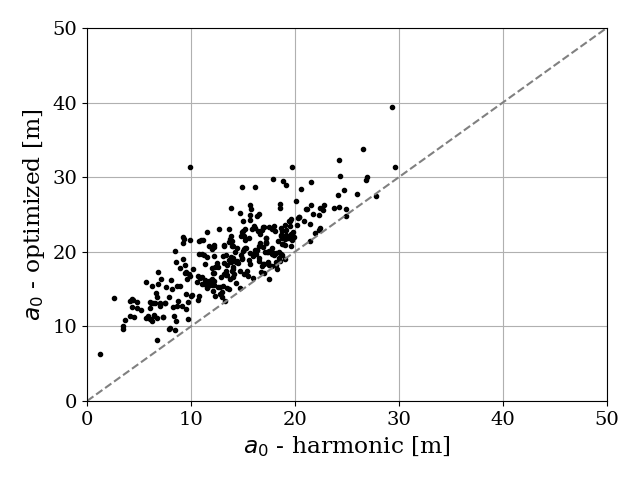

In [5]:
# Load the tidal harmonic estimate of a_0

# Load the amplitude and density data

ncfile = '/home/suntans/Share/ARCHub/DATA/FIELD/ShellCrux/KP150_Fitted_Buoyancy_wout_motion.nc'
mode=0
ds1 = xr.open_dataset(ncfile,group='KP150_phs1')
ds2 = xr.open_dataset(ncfile,group='KP150_phs2')

# Merge the two
A_n = xr.concat([ds1['A_n'][:,mode],ds2['A_n'][:,mode]], dim='time')
a0 = xr.concat([ds1['amp'][:,mode,0],ds2['amp'][:,mode,0]], dim='timeslow')

# Quality control
A_n.loc['2016-09-18':'2016-10-31']=np.nan
a0.loc['2016-09-18':'2016-10-31']=np.nan

# Create a time series of single days with the max amplitude and a guess at beta
#time1 = pd.date_range('2016-5-1','2016-9-15') 
#time2 = pd.date_range('2016-11-1','2017-5-1')

#time = time1.append(time2)
basetime = datetime(2016,1,1)

a0_harmonic = a0.sel(timeslow=data.index, method='nearest')
tdays_a0 = SecondsSince(a0_harmonic.timeslow.values,basetime=basetime)/86400.
a0_harmonic.timeslow.values
#a0.sel(timeslow=data.index,method='nearest')

plt.figure()
plt.plot(a0_harmonic, data['a0'], 'k.')
plt.plot([0,50],[0,50],'--',c='0.5')
plt.ylabel('$a_0$ - optimized [m]')
plt.xlabel('$a_0$ - harmonic [m]' )
plt.xlim(0,50)
plt.ylim(0,50)
plt.grid(b=True)
plt.tight_layout()

# Extract the tides at a point

In [30]:
# Load the tidal velocity
xpt, ypt = 123.346383, -13.75895

# Grab the barotropic tide data
tidemod = '/home/suntans/Share/ScottReef/DATA/TIDES/Ind2016/Model_Ind_2016'
#tidecons = ['M2','S2','N2','K2','K1','O1','P1','Q1']
tidecons = ['M2','S2','N2','K2',]
#tidecons = ['M2','S2',]

# This extract_phsamp function appears to be wrong so manually calculate the phase and amp

#ua,up,va,vp,ha,hp,omega = readotps.extract_phsamp(tidemod,np.array([xpt]),
#                        np.array([ypt]),basetime, tidecons)
#ha,hp

In [31]:
# Extract the tidal height for the whole period
time = TimeVector('20160501.000000','20170501.000000',3600)
eta, U,V = readotps.tide_pred(tidemod,np.array([xpt]),
                        np.array([ypt]),time)

#


Interpolating consituent: M2...
Interpolating consituent: S2...
Interpolating consituent: N2...
Interpolating consituent: K2...
Interpolating consituent: K1...
Interpolating consituent: O1...
Interpolating consituent: P1...
Interpolating consituent: Q1...


In [32]:
eta_ts = timeseries(time,eta)

eta_amp, eta_phs, omega,_,eta_harmonic,_=eta_ts.tidefit(frqnames=tidecons,basetime=basetime)

#plt.figure()
#eta_ts.plot()
#plt.plot(time,eta_harmonic)

omega

/home/suntans/code/soda/soda/utils/harmonic_analysis.py:139: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  b = np.linalg.lstsq(A,y)


[0.00014051890250864362,
 0.0001454441043328608,
 0.00013787969948654463,
 0.00014584231720055478]

In [33]:
# Hilbert transform to get the signal envelope
def sine_model_envelope(beta_s, ff, t):
    n = len(ff)
    
    result =0*t
    for ii in range(0,n):
        result += beta_s[2*ii]*np.cos(ff[ii] * t) + beta_s[2*ii+1]*np.sin(ff[ii]*t)
        
    # Compute the imaginary part by adding a 90 degree phase shift
    result_i =  0*t
    for ii in range(0,n):
        result_i += beta_s[2*ii]*np.cos(ff[ii] * t + np.pi/2) \
            + beta_s[2*ii+1]*np.sin(ff[ii]*t + np.pi/2)

    return np.abs(result +1j*result_i)


In [34]:
#h_re, h_im = pol2cart(hp,ha)
h_re, h_im = pol2cart(eta_phs.data, eta_amp.data)
nf = len(omega)
beta_s = np.zeros((2*nf,))
beta_s[0:-1:2] = h_re.ravel()
beta_s[1::2] = h_im.ravel()
beta_s,h_re


(array([-1.06487419, -0.73220241, -0.37527611,  0.61852572,  0.21994265,
        -0.03968925,  0.03619007, -0.15275128]),
 array([[-1.06487419, -0.37527611,  0.21994265,  0.03619007]]))

In [35]:
signal.hilbert(eta).shape

/home/suntans/.conda/envs/soda/lib/python3.6/site-packages/scipy/signal/signaltools.py:1585: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  h = h[ind]


(8761, 1)

In [36]:
# Compute the tidal envelope at all of our time points
t = data.index.values
tsec = SecondsSince(t,basetime=basetime)

h_env = sine_model_envelope(beta_s, omega, tsec)

h_env2 = np.abs( signal.hilbert(eta.ravel()))

<IPython.core.display.Javascript object>


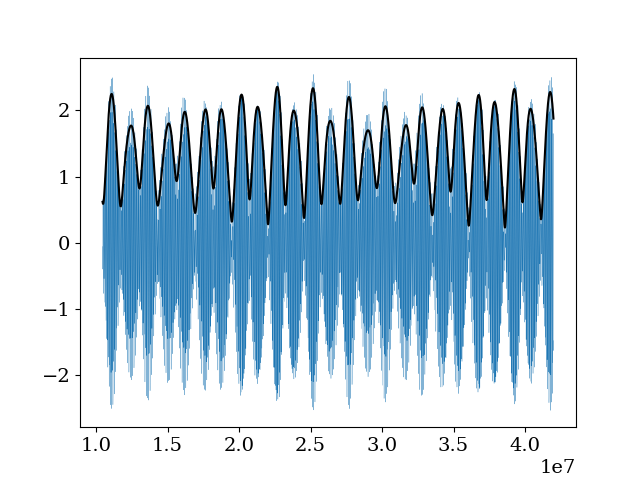

In [120]:
t_tides = SecondsSince(eta_ts.t, basetime=basetime)
h_env_full = sine_model_envelope(beta_s, omega, t_tides)
plt.figure()
plt.plot(t_tides, eta_ts.y.ravel(), lw=0.2)
plt.plot(t_tides, h_env_full,'k')
plt.plot(tsec, h_env,'r.')

ax

<IPython.core.display.Javascript object>


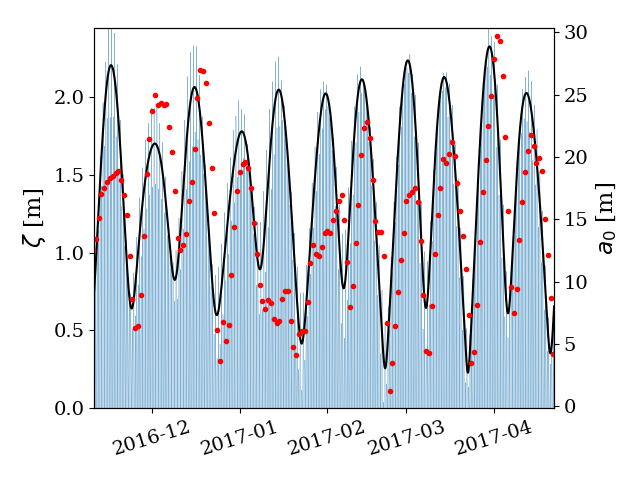

In [142]:

plt.figure()
plt.plot(eta_ts.t, eta_ts.y.ravel(), lw=0.2)
plt.plot(eta_ts.t, h_env_full,'k')
plt.ylabel('$\zeta$ [m]')

plt.xticks(rotation=17)
plt.ylim(0,2.5)

ax2=plt.twinx()
p2,=plt.plot(a0_harmonic.timeslow, a0_harmonic.values,'r.')
ax2.set_ylabel('$a_0$ [m]')
plt.xlim(datetime(2016,5,1),datetime(2017,5,1))

plt.tight_layout()

outfile = '../FIGURES/a0_zeta_input_series'
plt.savefig(outfile+'.pdf')
plt.savefig(outfile+'.png',dpi=150)

<IPython.core.display.Javascript object>


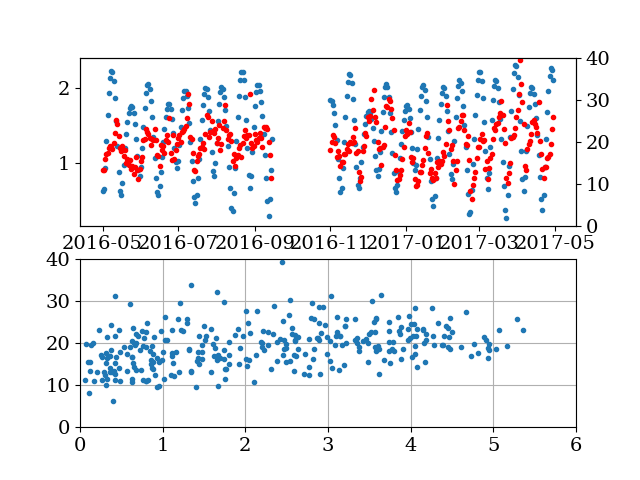

In [38]:
plt.figure()
plt.subplot(211)
#plt.plot(time, eta,'-',lw=0.2)
plt.plot(t, h_env,'.')
#plt.plot(time, h_env2,'--')

ax2 = plt.twinx()
ax2.plot(t,data.a0.values,'r.')
ax2.set_ylim(0,40)


plt.subplot(212)
plt.plot(h_env**2.,data.a0.values,'.')
plt.xlim(0,6)
plt.ylim(0,40)
plt.grid(b=True)

<IPython.core.display.Javascript object>


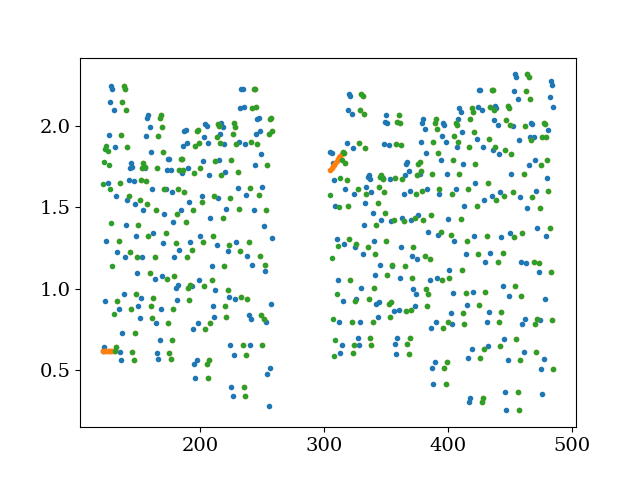

In [40]:
# Try a lagged regression

def lagtimeseries(x0, y0, lag):
    """
    x0 input x coordinate
    y0 input y coordinate
    
    x lagged value
    """
    lag = np.array(lag)
    x =  x0 - lag
    
    # Check the bounds
    x[x<x0[0]]=x0[0]
    x[x>x0[-1]]=x0[-1]


    idx = np.searchsorted(x0, x)
    #idx[idx<1]=1
    #shape=x0.shape[0]-1
    #idx[idx>shape]=shape
    
    # Nearest neighbour
    #return y0[idx - 1]

    dl = np.array(x - x0[idx - 1])
    dr = np.array(x0[idx] - x)
    d = dl + dr
    wl = dr / d

    return wl * y0[idx - 1] + (1 - wl) * y0[idx]


nlags = 20
lags = np.linspace(0,10,nlags)

tdays = tsec/86400

ylag = lagtimeseries(tdays, h_env, 10.)
ylag2 = sine_model_envelope(beta_s,omega,(tdays-10)*86400)

plt.figure()
plt.plot(tdays, h_env,'.')
plt.plot(tdays, ylag,'.')
plt.plot(tdays, ylag2,'.')


#with Model() as model:
#    coeff_sd = HalfCauchy('coeff_sd', 5)

    #y = GaussianRandomWalk('y', sd=coeff_sd, shape=(nlags,))

    #p = interpolate(knots, y, age,)

    #sd = HalfCauchy('sd', 5)

    #vals = Normal('vals', p, sd=sd, observed=rate)

In [148]:
from theano.compile.ops import as_op

@as_op(itypes=[tt.dvector, tt.dvector, tt.dscalar], otypes=[tt.dvector])
def lagtimeseries_pm(x0, y0, lag):
    """
    x0 input x coordinate
    y0 input y coordinate
    
    x lagged value
    """
    x =  x0 - lag
    
    # Check the bounds
    x[x<x0[0]]=x0[0]
    x[x>x0[-1]]=x0[-1]

    idx = tt.extra_ops.searchsorted(x0, x).eval()
    
    #return y0[idx - 1]

    dl = x - x0[idx - 1]
    dr = x0[idx] - x
    d = dl + dr
    wl = dr / d

    return wl * y0[idx - 1] + (1 - wl) * y0[idx]

def sine_model_envelope_pm(beta_s, ff, t):
    n = len(ff)
    
    #result = t*0
    
    result = tt.zeros(t.shape)

    for ii in range(0,n):
        result += beta_s[2*ii]*pm.math.cos(ff[ii] * t) + beta_s[2*ii+1]*pm.math.sin(ff[ii]*t)
        
    # Compute the imaginary part by adding a 90 degree phase shift
    #result_i = t*0
    result_i = tt.zeros(t.shape)

    for ii in range(0,n):
        result_i += beta_s[2*ii]*pm.math.cos(ff[ii] * t + np.pi/2) \
            + beta_s[2*ii+1]*pm.math.sin(ff[ii]*t + np.pi/2)
    
    return pm.math.sqrt(result*result + result_i*result_i)

# optimized a0
##lag = 2.02
#Y = data.a0.values
#tdays = SecondsSince(data.a0.index.values,basetime=basetime)/86400.
#outputh5 = '../inputs/a0_samples_optimal_a0_all_times.h5'

timestamp = datetime.now().strftime('%Y-%m-%d')
# Harmonic a0
#lag = 1.6
Y = a0_harmonic.values
tdays = shared(tdays_a0)
outputh5 = '../inputs/a0_samples_harmonic_a0_all_times_{}.h5'.format(timestamp)


with pm.Model() as model:
    
    # Scale
    alpha1 = pm.HalfCauchy('alpha1', 10)
    #alpha2 = pm.HalfCauchy('alpha2', 10)
    #alpha3 = pm.HalfCauchy('alpha3', 10)

    
    # offset
    beta = pm.HalfCauchy('beta', 10)    
    sd = pm.HalfCauchy('sd', 10)
    
    #coeff_sd = pm.HalfNormal('sd_coeff', 1)

    # lag
    #ylag = lagtimeseries_pm(tt.as_tensor(tdays), tt.as_tensor(h_env), lag)


    #lag=2.02
    # Scalar lag
    #ylag = lagtimeseries(tdays, h_env, lag)
    
    # Non-scalar lag
    lag = pm.HalfCauchy('lag', 1.)
    #ylag = lagtimeseries_pm(tt.as_tensor(tdays), tt.as_tensor(h_env), lag)
    
    # Alternative approach is to compute the lagged envelope function directly
    tsec = (tdays-lag)*86400.
    ylag = sine_model_envelope_pm(beta_s, omega, tsec)
    #ylag = pm.Deterministic('ylag',sine_model_envelope_pm(beta_s, omega, tsec))

    #ylag
    #lag = lagtimeseries_pm(tdays, h_env, lag)
    # This is not really necessary
    #ylag = pm.Deterministic('ylag', sine_model_envelope_pm(beta_s, omega, tsec))


    
    # Mean function
    #mu = pm.Deterministic('mu', alpha1*ylag + beta)
    # Cubic polynomial
    #mu = pm.Deterministic('mu', alpha3*ylag*ylag*ylag + alpha2*ylag*ylag + alpha1*ylag + beta)
    
    
    vals = pm.Normal('vals', alpha1*ylag + beta, sd=sd, observed=Y)
    #BoundedNormal = pm.Bound(pm.Normal, lower=0.0)
    #BoundedNormal('vals', alpha1*ylag + beta, sd=sd, observed=Y)
    
    #start = {'lag':1.}
    #start= pm.find_MAP()
    start=None
    #step1 = pm.Metropolis(vars=[lag])
    #step2 = pm.NUTS(vars=[alpha1,beta,sd])
    trace = pm.sample(500, tune=1500,step = pm.NUTS(), start=start, chains=4)
    #trace = pm.sample(500, tune=1500,step =[step1,step2], start=start, chains=1)

    #print(pm.find_MAP())
    
    
pm.summary(trace)

Multiprocess sampling (4 chains in 4 jobs)
NUTS: [lag, sd, beta, alpha1]
Sampling 4 chains: 100%|██████████| 8000/8000 [00:12<00:00, 618.94draws/s]
The acceptance probability does not match the target. It is 0.8808854923612909, but should be close to 0.8. Try to increase the number of tuning steps.


,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
alpha1,6.350722,0.433173,0.014408,5.473085,7.159411,918.354694,0.999988
beta,5.339498,0.648084,0.021588,4.071245,6.638066,928.044617,1.000166
sd,4.127582,0.165137,0.004072,3.825561,4.445720,1616.707540,1.000089
lag,1.417841,0.156477,0.003916,1.078929,1.695275,1560.887873,0.999821


/home/suntans/.conda/envs/soda/lib/python3.6/site-packages/arviz/data/io_pymc3.py:56: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  chain_likelihoods.append(np.stack(log_like))


<IPython.core.display.Javascript object>


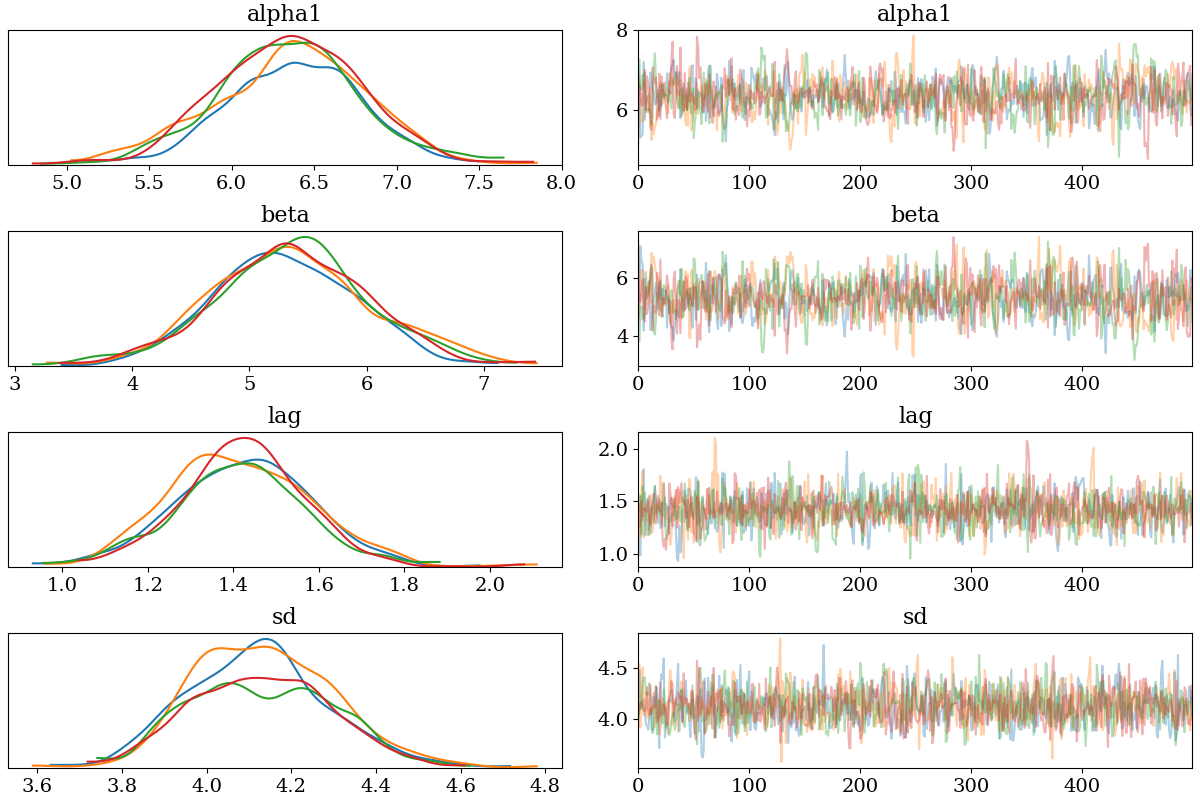

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f6e2d026c18>,
      dtype=object)

In [149]:
pm.traceplot(trace,var_names=['alpha1','beta','lag','sd'])

In [150]:
tnew = rhotime
tsecnew = SecondsSince(tnew,basetime=basetime)
tdaynew = tsecnew/86400.

# Use the built-in function for prediction
nsamples = 500
tdays.set_value(tdaynew)
ppc = pm.sample_posterior_predictive(trace, model=model, samples=nsamples)

a0_pred = ppc['vals']


100%|██████████| 500/500 [00:02<00:00, 225.89it/s]


<IPython.core.display.Javascript object>


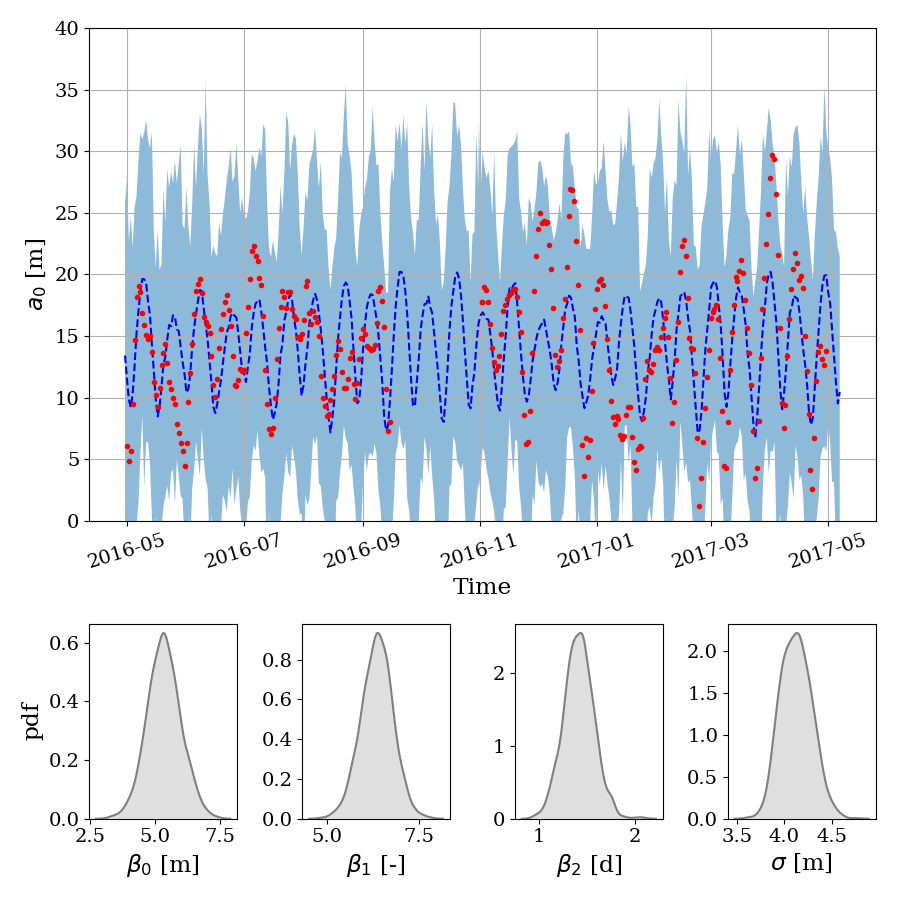

/home/suntans/.conda/envs/soda/lib/python3.6/site-packages/scipy/stats/stats.py:1706: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval
/home/suntans/.conda/envs/soda/lib/python3.6/site-packages/matplotlib/cbook/__init__.py:1725: UserWarning: Saw kwargs ['c', 'color'] which are all aliases for 'color'.  Kept value from 'color'
  seen=seen, canon=canonical, used=seen[-1]))


In [151]:
#trace.mu.shape, tdays.shape
plt.figure(figsize=(9,9))

plt.subplot2grid((3,4),(0,0), rowspan=2,colspan=4)
#plt.plot(tdays, np.median(samples['vals'],axis=0),'k--')
#plt.fill_between(tdays, np.percentile(samples['vals'],1.0,axis=0),\
#                 np.percentile(samples['vals'],99.,axis=0),alpha=0.5)

p1,=plt.plot(tnew, np.median(a0_pred,axis=0),'b--')
#plt.fill_between(tnew, np.percentile(a0_pred,0.5,axis=0),\
#                 np.percentile(a0_pred,99.5,axis=0),alpha=0.5)
plt.fill_between(tnew, np.min(a0_pred,axis=0),\
                 np.max(a0_pred,axis=0),alpha=0.5)

#plt.fill_between(tnew, np.min(a0_pred2,axis=0),\
#                 np.max(a0_pred2,axis=0),alpha=0.5)

#plt.plot(data.index.values,data.a0.values,'r.')
p2,=plt.plot(a0_harmonic.timeslow, a0_harmonic.values,'r.')


#ax2 = plt.twinx()
#ax2.plot(tdays,h_env,'g--')

#plt.xlim(100,500)
plt.ylim(0,40)
plt.ylabel('$a_0$ [m]')
plt.xlabel('Time')
plt.xticks(rotation=17)
plt.grid(b=True)
plt.tight_layout()

ax=plt.subplot2grid((3,4),(2,0),)
sns.kdeplot(trace['beta'], shade=True, c='0.5')
plt.xlabel(r'$\beta_0$ [m]')
plt.ylabel('pdf')

ax=plt.subplot2grid((3,4),(2,1),)
sns.kdeplot(trace['alpha1'], shade=True, c='0.5')
plt.xlabel(r'$\beta_1$ [-]')

ax=plt.subplot2grid((3,4),(2,2),)
sns.kdeplot(trace['lag'], shade=True, c='0.5')
plt.xlabel(r'$\beta_2$ [d]')

ax=plt.subplot2grid((3,4),(2,3),)
sns.kdeplot(trace['sd'], shade=True, c='0.5')
plt.xlabel(r'$\sigma$ [m]')

plt.tight_layout()

outfile = '../FIGURES/a0_mcmc_series'
plt.savefig(outfile+'.pdf')
plt.savefig(outfile+'.png',dpi=150)

In [152]:
# Output the data

f = h5py.File(outputh5,'w')
g = f.create_group('data')
g.create_dataset('a0-all-times-samples',data=a0_pred.T)
g.create_dataset('time',data=tdaynew)
f.close()
print(outputh5)

../inputs/a0_samples_harmonic_a0_all_times_2019-07-12.h5


In [ ]:
# Use minimization to find alpha, beta and tlag
def amp_response(coeffs,t, h_in):
    alpha, beta, lag = coeffs
    #ylag = lagtimeseries(t, h_in, lag)
    ylag = sine_model_envelope(beta_s, omega, t+lag)

    mu = alpha*ylag + beta
    
    return mu
def fdiff(coeffs, t, h_in, h_out):
    
    mu = amp_response(coeffs, t, h_in,)
    return np.linalg.norm(h_out - mu)

# Use the optimized a0
soln = minimize(fdiff, np.array([0,1,1]), args=(tdays, h_env, data.a0.values),
        )#bounds=[(0,10),(0,30),(0,30)])

# Use the harmonic a0 values 
soln2 = minimize(fdiff, np.array([0,1,1]), args=(tdays, h_env, a0_harmonic),
        )#bounds=[(0,10),(0,30),(0,30)])


h_op = amp_response(soln['x'], tdays, h_env)
h_op2 = amp_response(soln2['x'], tdays, h_env)

soln, soln2

<IPython.core.display.Javascript object>


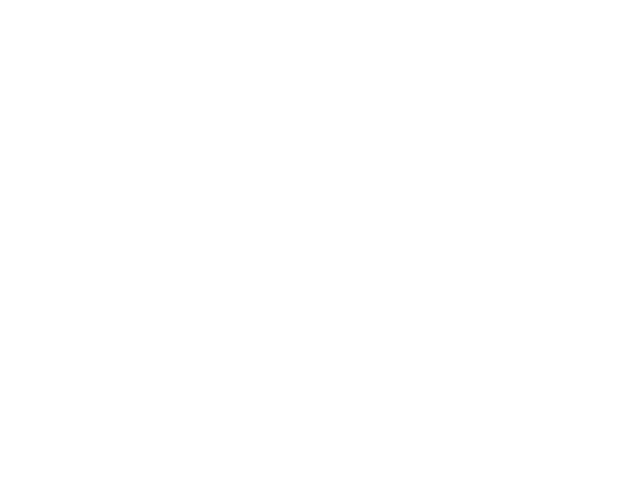

NameError: name 'samples' is not defined

In [56]:
plt.figure()
plt.plot(tdays, np.median(samples['vals'],axis=0),'k--')
plt.fill_between(tdays, np.percentile(samples['vals'],1.0,axis=0),\
                 np.percentile(samples['vals'],99.,axis=0),alpha=0.5)

plt.plot(tdays,data.a0.values,'r.')
plt.plot(tdays,a0_harmonic,'g.')


plt.plot(tdays,h_op,'--')
plt.plot(tdays,h_op2,'g--')


#ax2 = plt.twinx()
#ax2.plot(tdays,h_env,'g--')

plt.ylim(0,40)
plt.grid(b=True)

In [59]:
# Save the result to an amplitude hdf5 file
#testh5 = '../inputs/2018-05-22_a0-samples-at-all-times.h5'
outputh5 = '../inputs/a0_samples_optimal_a0_all_times.h5'

f = h5py.File(outputh5,'r')
for kk in f['data'].keys():
    print(kk)
    
print(f['data']['a0-all-times-samples'].shape)
f.close()

a0-all-times-samples
time
(1480, 1000)


In [60]:
print(a0_pred.shape)
f.close()

(1000, 1480)
